In [11]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import os

In [12]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calcula a distância Haversine entre dois pontos na Terra.
    Retorna a distância em metros.
    """
    R = 6371000  # raio médio da Terra em metros
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

In [57]:
def terminal_in_points(lon_t, lat_t, df_points, lon_col='LON_CLUSTER', lat_col='LAT_CLUSTER', threshold=100):
    if df_points.empty:
        return False
    
    lons = df_points[lon_col].to_numpy()
    lats = df_points[lat_col].to_numpy()

    dists = haversine_np(
        np.full_like(lons, lon_t, dtype=float),
        np.full_like(lats, lat_t, dtype=float),
        lons,
        lats
    )
    return (dists <= threshold).any()

In [58]:
def codifica(temA, temB):
        if temA and temB:
            return 'AB'
        elif temA:
            return 'A'
        elif temB:
            return 'B'
        else:
            return None

In [68]:
def distancia_k(df, limite_ruido=7, max_onibus=5, min_registros=1000, plot_rota=True):
    pontos_por_linha = {
        "343": {
            "A": [-43.31261, -23.00516],
            "B": [-43.19369, -22.90568]
        },
        "232": {
            "A": [-43.29042, -22.90076],
            "B": [-43.18941, -22.90825]
        },
        "390": {
            "A": [-43.39373, -22.95652],
            "B": [-43.19241, -22.90532]
        },
        "455": {
            "A": [-43.28039, -22.89977],
            "B": [-43.19089, -22.98671]
        },
        "600": {
            "A": [-43.40513, -22.91282],
            "B": [-43.22491, -22.92070]
        }
    }

    linhas = []

    for linha, terminais in pontos_por_linha.items():
        for terminal, coords in terminais.items():
            lon, lat = coords
            linhas.append({
                "LINE": linha,
                "TERMINAL": terminal,
                "LONGITUDE": lon,
                "LATITUDE": lat
            })

    df_terminais = pd.DataFrame(linhas)
    # --- limpeza e validações iguais às suas ---
    if 'PARKING' in df.columns:
        df = df[df['PARKING'].isna()]

    colunas_necessarias = ['GPSTIMESTAMP', 'LATITUDE', 'LONGITUDE', 'BUSID']
    if not all(col in df.columns for col in colunas_necessarias):
        raise ValueError(f"Faltam colunas obrigatórias: {colunas_necessarias}")

    df = df.copy()
    df['GPSTIMESTAMP'] = pd.to_datetime(df['GPSTIMESTAMP'], errors='coerce')
    df = df.dropna(subset=['GPSTIMESTAMP', 'LATITUDE', 'LONGITUDE', 'BUSID'])
    if df.empty:
        print("⚠️ DataFrame vazio após limpeza. Nada para plotar.")
        return

    line = df['LINE'].iloc[0] if 'LINE' in df.columns and not df['LINE'].isna().all() else 'N/D'
    contagem = df.groupby('BUSID')['GPSTIMESTAMP'].count()
    onibus_validos = contagem[contagem >= min_registros].index
    df = df[df['BUSID'].isin(onibus_validos)]
    if df.empty:
        print(f"⚠️ Nenhum ônibus com pelo menos {min_registros} registros encontrado.")
        return

    unique_ids = df['BUSID'].unique()
    sample_ids = np.random.choice(unique_ids, size=min(max_onibus, unique_ids.size), replace=False)

    # Para o mapa: listas com pontos por categoria
    pontos_vermelhos = []
    pontos_laranja = []
    pontos_amarelo = []
    df_pp = pd.DataFrame(columns=['LAT', 'LON', 'BUSID', 'TIMES'])

    # --------- GRÁFICO DISTÂNCIA x TEMPO (igual ao seu) ----------
    plt.figure(figsize=(12, 6))
    global_min_t = global_max_t = None

    for busid in sample_ids:
        df_temp = df[df['BUSID'] == busid].copy().sort_values('GPSTIMESTAMP')
        if df_temp.shape[0] < 2:
            continue

        lat = df_temp['LATITUDE'].to_numpy()
        lon = df_temp['LONGITUDE'].to_numpy()

        dist_segmentos = haversine_np(lon[:-1], lat[:-1], lon[1:], lat[1:])
        dist_segmentos = np.where(dist_segmentos < limite_ruido, 0, dist_segmentos)
        dist_acumulada = np.insert(np.cumsum(dist_segmentos), 0, 0.0)

        df_temp = df_temp.iloc[:len(dist_acumulada)].copy()
        df_temp['DISTANCIA_ACUMULADA'] = dist_acumulada

        # ---- DETECÇÃO DE SEQUÊNCIAS DE PARADA ----
        # stopped = True quando não houve aumento de distância entre amostras
        delta = df_temp['DISTANCIA_ACUMULADA'].diff().fillna(0.0)

        # mais robusto que eq(0):
        stopped = pd.Series(np.isclose(delta.to_numpy(), 0.0, atol=1e-6), index=df_temp.index)

        # grupos de runs True/False
        grupos = (stopped != stopped.shift(1)).cumsum()
        tam_run = stopped.groupby(grupos).transform('size')

        mask_vermelho = stopped & (tam_run >= 20)                 # ≥10 pts (~10 min)
        mask_laranja = stopped & (tam_run >= 10) & (tam_run < 20) # 3..9 pts (~5–9,5 min)
        mask_amarelo   = stopped & (tam_run >= 3) & (tam_run < 10)  # 3..9 pts (~1,5–4,5 min)
        mask_parado = stopped

        df_parado = df_temp[mask_parado].copy()
        if not df_parado.empty:
            # arredonda coordenadas pra agrupar pontos próximos como o mesmo lugar
            df_parado['LAT'] = df_parado['LATITUDE'].round(5)
            df_parado['LON'] = df_parado['LONGITUDE'].round(5)
            df_parado['BUSID'] = busid

            # conta quantas vezes (amostras) ele ficou parado em cada ponto
            agg = (
                df_parado
                .groupby(['BUSID', 'LAT', 'LON'])
                .size()
                .reset_index(name='TIMES')
            )

            # acumula no df_pp global
            df_pp = pd.concat([df_pp, agg], ignore_index=True)

        # guarda coordenadas para o mapa
        if mask_vermelho.any():
            pontos_vermelhos.append(df_temp.loc[mask_vermelho, ['LONGITUDE', 'LATITUDE']])
        if mask_amarelo.any():
            pontos_amarelo.append(df_temp.loc[mask_amarelo, ['LONGITUDE', 'LATITUDE']])
        if mask_laranja.any():
            pontos_laranja.append(df_temp.loc[mask_laranja, ['LONGITUDE', 'LATITUDE']])

        # curva distância x tempo
        plt.plot(df_temp['GPSTIMESTAMP'], df_temp['DISTANCIA_ACUMULADA'], label=f'Ônibus {busid}')

        tmin, tmax = df_temp['GPSTIMESTAMP'].min(), df_temp['GPSTIMESTAMP'].max()
        global_min_t = tmin if global_min_t is None else min(global_min_t, tmin)
        global_max_t = tmax if global_max_t is None else max(global_max_t, tmax)

    if not df_pp.empty:
        df_pp = (
            df_pp
            .groupby(['BUSID', 'LAT', 'LON'], as_index=False)['TIMES']
            .sum()
        )
        df_pp = df_pp.reset_index(drop=True)

        coords = df_pp[['LAT', 'LON']].to_numpy()
        times = df_pp['TIMES'].to_numpy()

        # vamos criar uma coluna de cluster
        df_pp['cluster'] = -1

        # ordem dos pontos: do maior TIMES pro menor
        order = np.argsort(-times)

        cluster_id = 0
        used = np.zeros(len(df_pp), dtype=bool)

        for idx in order:
            if used[idx]:
                continue

            # esse ponto será o centro do novo cluster
            lat0, lon0 = coords[idx]

            # distância do centro para todos os pontos
            dists = haversine_np(
                np.full(len(coords), lon0),
                np.full(len(coords), lat0),
                coords[:, 1],  # lon
                coords[:, 0],  # lat
            )

            # membros do cluster: ainda não usados e até 100m
            membros = np.where((~used) & (dists <= 100))[0]

            df_pp.loc[membros, 'cluster'] = cluster_id
            used[membros] = True
            cluster_id += 1

            idx_rep = df_pp.groupby('cluster')['TIMES'].idxmax()

            representantes = df_pp.loc[idx_rep, ['cluster', 'LAT', 'LON']].rename(
                columns={'LAT': 'LAT_CLUSTER', 'LON': 'LON_CLUSTER'}
            )
            df_cluster = (
                df_pp
                .groupby(['cluster', 'BUSID'], as_index=False)['TIMES']
                .sum()
            )

            # junta as coordenadas do representante do cluster
            df_cluster = df_cluster.merge(representantes, on='cluster', how='left')
            n_onibus = df_cluster['BUSID'].nunique()
            clusters_comuns = (
                df_cluster
                .groupby('cluster')['BUSID']
                .nunique()
                .reset_index(name='N_ONIBUS')
            )

            clusters_todos = clusters_comuns[clusters_comuns['N_ONIBUS'] == n_onibus]['cluster']
            df_comum = df_cluster[df_cluster['cluster'].isin(clusters_todos)].copy()
            resumo_pontos_comuns = (
                df_comum
                .groupby(['cluster', 'LAT_CLUSTER', 'LON_CLUSTER'], as_index=False)['TIMES']
                .sum()
                .rename(columns={'TIMES': 'TOTAL_TIMES'})
            )
            resumo_pontos_comuns = resumo_pontos_comuns.sort_values(by='TOTAL_TIMES', ascending=False)

    if global_min_t is None:
        print("⚠️ Não há séries com 2+ pontos para plotar.")
        return

    xticks = pd.date_range(start=global_min_t.floor('H'),
                           end=(global_max_t.floor('H') + pd.Timedelta(hours=1)),
                           freq='30min')
    plt.xticks(xticks, [t.strftime('%H:%M') for t in xticks], rotation=45)
    plt.title(f'Distância acumulada em função do tempo - Linha {line}')
    plt.xlabel('Hora'); plt.ylabel('Distância acumulada (m)')
    plt.grid(True, linestyle='--', alpha=0.7); plt.legend(); plt.tight_layout()
    plt.show()

    tem_A_top2 = False
    tem_B_top2 = False
    tem_A_any  = False
    tem_B_any  = False
    df_terminais['LINE'] = pd.to_numeric(df_terminais['LINE'], errors='coerce').astype('Int64')
    line_num = int(line)
    if (df_terminais['LINE'] == line_num).any():
        print("")
        df_term_line = df_terminais[df_terminais['LINE'] == line].copy()    
        
        top2 = resumo_pontos_comuns.head(2).copy()
        for _, row_t in df_term_line.iterrows():
            terminal_t = row_t['TERMINAL']
            lon_t   = row_t['LONGITUDE']
            lat_t   = row_t['LATITUDE']
            if terminal_t == 'A':
                tem_A_top2 = terminal_in_points(lon_t, lat_t, top2) or tem_A_top2
                tem_A_any  = terminal_in_points(lon_t, lat_t, resumo_pontos_comuns) or tem_A_any

            elif terminal_t == 'B':
                tem_B_top2 = terminal_in_points(lon_t, lat_t, top2) or tem_B_top2
                tem_B_any  = terminal_in_points(lon_t, lat_t, resumo_pontos_comuns) or tem_B_any
            
        terminal_top2 = codifica(tem_A_top2, tem_B_top2)
        terminal_any  = codifica(tem_A_any, tem_B_any)
        df_nova_linha = pd.DataFrame([{
            'LINE': line,
            'terminal_top2': terminal_top2,  # terminais presentes nos 2 pontos mais importantes
            'terminal_any': terminal_any     # terminais presentes em qualquer ponto de resumo_pontos_comuns
        }])
    else:
        df_nova_linha = pd.DataFrame()


    # --------- MAPA/ROTA COM MARCAÇÃO DE SEQUÊNCIAS ----------
    if plot_rota:
        plt.figure(figsize=(8, 8))

        # Desenha a rota (todas as amostras) de cada ônibus
        for busid in sample_ids:
            df_temp = df[df['BUSID'] == busid].sort_values('GPSTIMESTAMP')
            plt.plot(df_temp['LONGITUDE'], df_temp['LATITUDE'], alpha=0.5, label=f'Ônibus {busid}', zorder=1)

        dfA = df_term_line[df_term_line['TERMINAL'] == 'A']
        if not dfA.empty:
            plt.scatter(
                dfA['LONGITUDE'], 
                dfA['LATITUDE'],
                s=80,
                marker='X',
                color='blue',
                label='Terminal A',
                zorder=4
            )

        # Terminais B (verde)
        dfB = df_term_line[df_term_line['TERMINAL'] == 'B']
        if not dfB.empty:
            plt.scatter(
                dfB['LONGITUDE'], 
                dfB['LATITUDE'],
                s=80,
                marker='X',
                color='green',
                label='Terminal B',
                zorder=4
            )    

        if resumo_pontos_comuns is not None and not resumo_pontos_comuns.empty:
            valores = resumo_pontos_comuns['TOTAL_TIMES'].to_numpy()

            vmin = valores.min()
            vmax = valores.max()
            # normaliza pra [0, 1]
            norm = (valores - vmin) / (vmax - vmin + 1e-9)
            # inverte: max tempo → 0 (vermelho), min tempo → 1 (amarelo)
            norm_inv = 1 - norm

            sc = plt.scatter(
                resumo_pontos_comuns['LON_CLUSTER'],
                resumo_pontos_comuns['LAT_CLUSTER'],
                s=40,
                marker='o',
                c=norm_inv,
                cmap='autumn',
                label='Pontos em comum a todos os ônibus',
                zorder=3
            )

            cbar = plt.colorbar(sc)
            cbar.set_label('Tempo em comum (TOTAL_TIMES)')
            
        

        plt.title(f'Rota — Linha {line}\nSequências de parada destacadas')
        plt.xlabel('Longitude'); plt.ylabel('Latitude')
        plt.grid(True, linestyle='--', alpha=0.5); plt.legend(); plt.tight_layout()
        plt.show()
    return df_pp, df_nova_linha
    


In [66]:
if __name__ == "__main__":
    diretorio = "../data/bus_csv/sul"
    arquivos_csv = glob.glob(os.path.join(diretorio, "*.csv"))
    dataframes = [pd.read_csv(arquivo) for arquivo in arquivos_csv]
    df_parados = pd.DataFrame()

    for df in dataframes:        
        df_parado, df_terminal = distancia_k(df, limite_ruido=7, max_onibus=5, plot_rota=True)
        print(df_parado)


C:\Users\bruno\AppData\Local\Temp\ipykernel_16708\2176156762.py:121: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pp = pd.concat([df_pp, agg], ignore_index=True)
C:\Users\bruno\AppData\Local\Temp\ipykernel_16708\2176156762.py:215: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  xticks = pd.date_range(start=global_min_t.floor('H'),
C:\Users\bruno\AppData\Local\Temp\ipykernel_16708\2176156762.py:216: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end=(global_max_t.floor('H') + pd.Timedelta(hours=1)),


KeyboardInterrupt: 

In [73]:
df_terminal2

,LINE,terminal_top2,terminal_any
0,232,A,AB


In [74]:
df_terminal3

,LINE,terminal_top2,terminal_any
0,390,None,None


C:\Users\bruno\AppData\Local\Temp\ipykernel_16708\481696575.py:121: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pp = pd.concat([df_pp, agg], ignore_index=True)
C:\Users\bruno\AppData\Local\Temp\ipykernel_16708\481696575.py:215: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  xticks = pd.date_range(start=global_min_t.floor('H'),
C:\Users\bruno\AppData\Local\Temp\ipykernel_16708\481696575.py:216: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end=(global_max_t.floor('H') + pd.Timedelta(hours=1)),


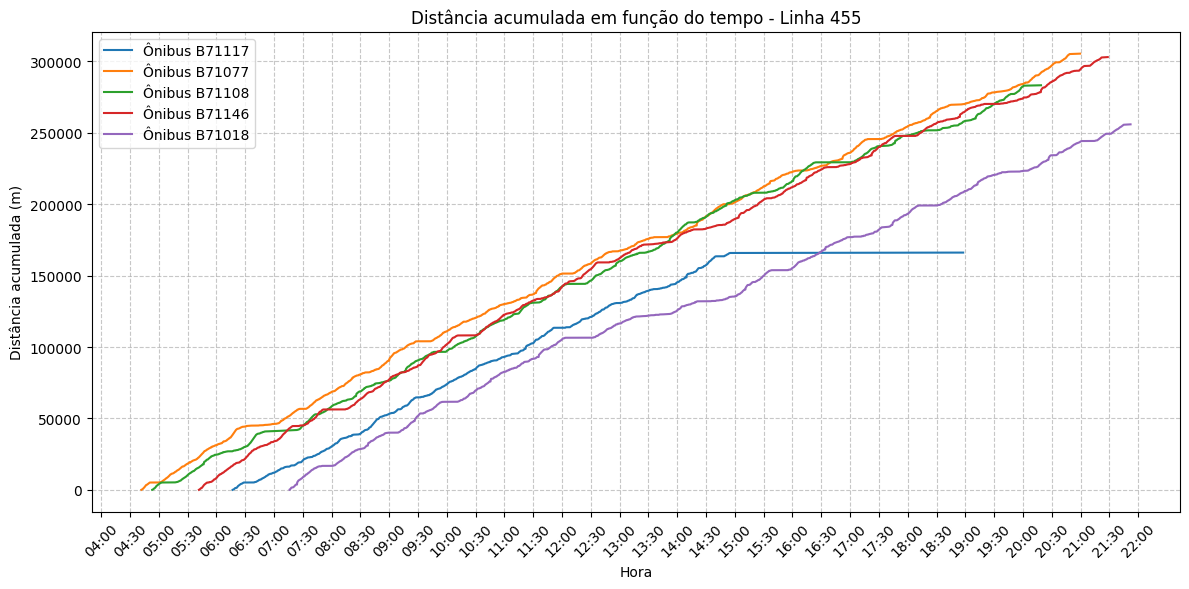

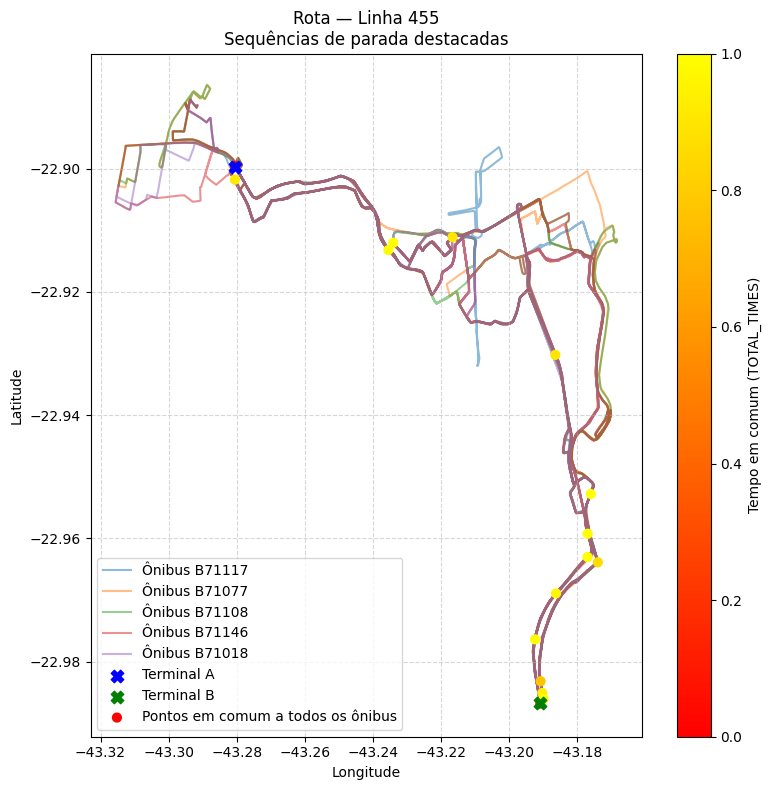

C:\Users\bruno\AppData\Local\Temp\ipykernel_16708\481696575.py:121: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pp = pd.concat([df_pp, agg], ignore_index=True)
C:\Users\bruno\AppData\Local\Temp\ipykernel_16708\481696575.py:215: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  xticks = pd.date_range(start=global_min_t.floor('H'),
C:\Users\bruno\AppData\Local\Temp\ipykernel_16708\481696575.py:216: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end=(global_max_t.floor('H') + pd.Timedelta(hours=1)),


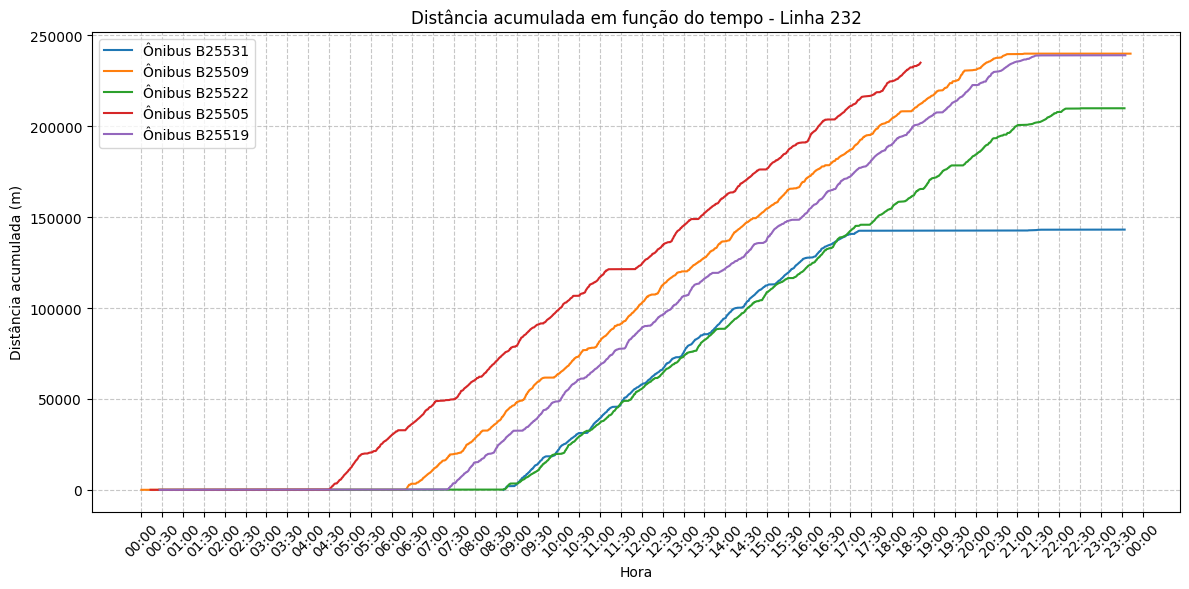

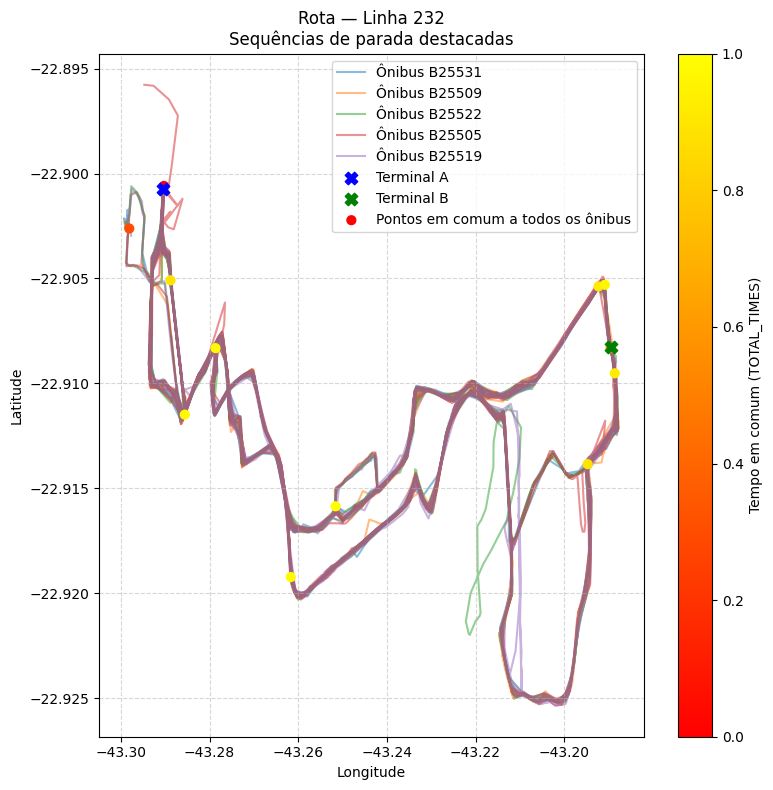

C:\Users\bruno\AppData\Local\Temp\ipykernel_16708\481696575.py:121: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_pp = pd.concat([df_pp, agg], ignore_index=True)
C:\Users\bruno\AppData\Local\Temp\ipykernel_16708\481696575.py:215: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  xticks = pd.date_range(start=global_min_t.floor('H'),
C:\Users\bruno\AppData\Local\Temp\ipykernel_16708\481696575.py:216: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  end=(global_max_t.floor('H') + pd.Timedelta(hours=1)),


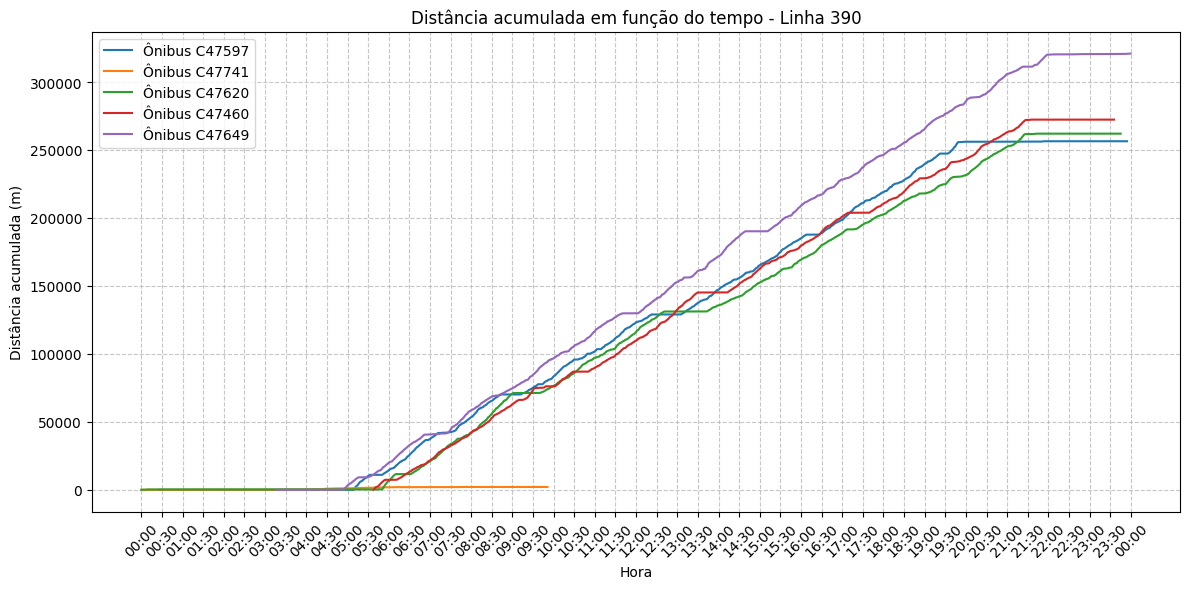

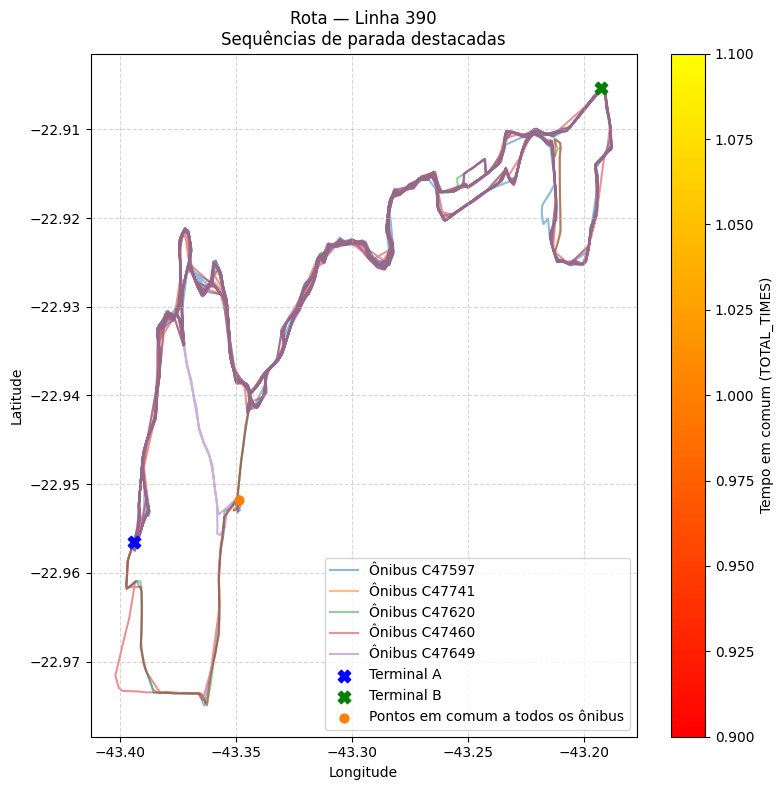

In [71]:
df = pd.read_csv('../data/bus_csv/sul/LINHA_455_COMPLETO.csv', sep=',')
df2 = pd.read_csv('../data/bus_csv/centro/LINHA_232_COMPLETO.csv', sep=',')
df3 = pd.read_csv('../data/bus_csv/centro/LINHA_390_COMPLETO.csv', sep=',')

df_parado, df_terminal = distancia_k(df, limite_ruido=7, max_onibus=5, plot_rota=True)
df_parado2, df_terminal2 = distancia_k(df2, limite_ruido=7, max_onibus=5, plot_rota=True)
df_parado3, df_terminal3 = distancia_k(df3, limite_ruido=7, max_onibus=5, plot_rota=True)

In [39]:
import numpy as np

# garante índice simples
df_pp = df_pp.reset_index(drop=True)

coords = df_pp[['LAT', 'LON']].to_numpy()
times = df_pp['TIMES'].to_numpy()

# vamos criar uma coluna de cluster
df_pp['cluster'] = -1

# ordem dos pontos: do maior TIMES pro menor
order = np.argsort(-times)

cluster_id = 0
used = np.zeros(len(df_pp), dtype=bool)

for idx in order:
    if used[idx]:
        continue

    # esse ponto será o centro do novo cluster
    lat0, lon0 = coords[idx]

    # distância do centro para todos os pontos
    dists = haversine_np(
        np.full(len(coords), lon0),
        np.full(len(coords), lat0),
        coords[:, 1],  # lon
        coords[:, 0],  # lat
    )

    # membros do cluster: ainda não usados e até 100m
    membros = np.where((~used) & (dists <= 100))[0]

    df_pp.loc[membros, 'cluster'] = cluster_id
    used[membros] = True
    cluster_id += 1


In [ ]:
# pega o índice do ponto com maior TIMES dentro de cada cluster
idx_rep = df_pp.groupby('cluster')['TIMES'].idxmax()

representantes = df_pp.loc[idx_rep, ['cluster', 'LAT', 'LON']].rename(
    columns={'LAT': 'LAT_CLUSTER', 'LON': 'LON_CLUSTER'}
)
df_cluster = (
    df_pp
    .groupby(['cluster', 'BUSID'], as_index=False)['TIMES']
    .sum()
)

# junta as coordenadas do representante do cluster
df_cluster = df_cluster.merge(representantes, on='cluster', how='left')
n_onibus = df_cluster['BUSID'].nunique()
clusters_comuns = (
    df_cluster
    .groupby('cluster')['BUSID']
    .nunique()
    .reset_index(name='N_ONIBUS')
)

clusters_todos = clusters_comuns[clusters_comuns['N_ONIBUS'] == n_onibus]['cluster']
df_comum = df_cluster[df_cluster['cluster'].isin(clusters_todos)].copy()
resumo_pontos_comuns = (
    df_comum
    .groupby(['cluster', 'LAT_CLUSTER', 'LON_CLUSTER'], as_index=False)['TIMES']
    .sum()
    .rename(columns={'TIMES': 'TOTAL_TIMES'})
)
resumo_pontos_comuns = resumo_pontos_comuns.sort_values(by='TOTAL_TIMES', ascending=False)

In [44]:
resumo_pontos_comuns = resumo_pontos_comuns.sort_values(by='TOTAL_TIMES', ascending=False)

resumo_pontos_comuns

,cluster,LAT_CLUSTER,LON_CLUSTER,TOTAL_TIMES
0,0,-22.91621,-43.25093,299
7,15,-22.97957,-43.22637,70
1,5,-22.97914,-43.23130,50
6,14,-22.93051,-43.18618,50
4,11,-22.92064,-43.19378,42
5,12,-22.96234,-43.17480,34
10,21,-22.96422,-43.17434,29
8,16,-22.91900,-43.25385,23
23,86,-22.98498,-43.22528,19
2,9,-22.92053,-43.22277,19
